In [1]:
import geopandas as gpd
import pandas as pd
from sklearn import metrics
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

from core.generate_clusters import process_single_region_morphotopes
from core.utils import used_keys

from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Lato"]


In [2]:
tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
buildings_dir = "/data/uscuni-ulce/processed_data/buildings/"
streets_dir = "/data/uscuni-ulce/processed_data/streets/"
enclosures_dir = "/data/uscuni-ulce/processed_data/enclosures/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'

In [3]:
test_dir = "/data/uscuni-ulce/sensitivity/"

In [4]:
sizes = [10, 25, 50, 75, 100, 125, 150, 175, 200, 250]

In [163]:
def calculate_inertia(X, labels):
    # Ensure X is a DataFrame for easy grouping
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
      
    def cluster_sq_dist(group):
        # Calculate centroid for the group
        centroid = group.mean(axis=0)
        # Sum of squared distances: sum((points - centroid)^2)
        return np.sum((group - centroid) ** 2).sum()

    # Group by label, exclude the label column itself from calculation
    inertia = X.groupby(labels.values).apply(cluster_sq_dist).sum()
        
    return inertia

def calculate_penalized_inertia(X, labels):
    # Get basic stats
    n_samples, n_features = X.shape
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    
    # Calculate base inertia (using the groupby logic)
    df = pd.DataFrame(X)
    df['_label'] = labels.values
    
    inertia = df.groupby('_label').apply(
        lambda g: np.sum((g - g.mean(axis=0))**2).sum()
    ).sum()

    bic = n_samples * np.log(1 / n_samples) + k * np.log(n_samples) * n_features

    return bic
    
    # if penalty_type == 'bic':
    #     # BIC penalty: ln(n) * total parameters
    #     # Parameters = k clusters * d dimensions
    #     penalty = k * np.log(n_samples) * n_features
    # elif penalty_type == 'aic':
    #     # AIC penalty: 2 * total parameters
    #     penalty = 2 * k * n_features
    # else:
    #     penalty = 0
        
    # return inertia + penalty

In [41]:
def get_morphotopes(min_cluster_size, region_id):
    process_single_region_morphotopes(
        region_id, 
        graph_dir,
        buildings_dir,
        streets_dir,
        enclosures_dir,
        tessellations_dir,
        chars_dir, 
        test_dir,
        min_cluster_size=min_cluster_size,
        generate_data=False,
    )

ERROR! Session/line number was not unique in database. History logging moved to new session 236


In [196]:
# prague
region_id = 69333
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [ ]:
%%time

n_jobs = -1
scores = Parallel(n_jobs=n_jobs)(
    delayed(get_morphotopes)(size, region_id) for size in sizes
)

In [197]:
scaler = StandardScaler()
vals = scaler.fit_transform(X_train[X_train.index >= 0])
vals = np.nan_to_num(vals, 0)

In [198]:
iner = []
noise = []
for s in sizes:
    mt = pd.read_parquet(f'/data/uscuni-ulce/sensitivity/tessellation_labels_morphotopes_{region_id}_{s}_0_None_None_False.pq')
    noise_mask = mt.morphotope_label.str.contains("-1")
    noise.append(noise_mask.sum() / noise_mask.shape[0])
    cal = calculate_inertia(vals[~noise_mask], mt.morphotope_label[~noise_mask])
    iner.append(cal)   

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a s

<Axes: >

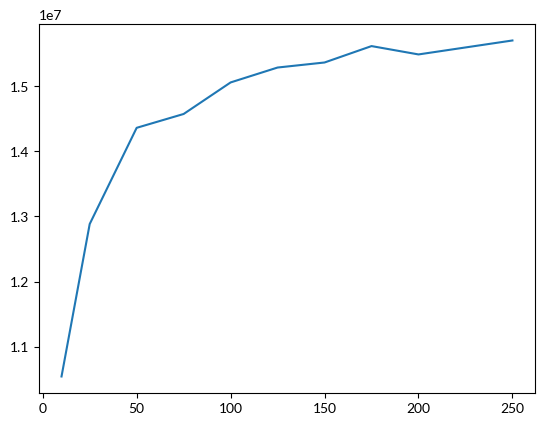

In [171]:
pd.Series(iner, index=sizes).plot()

<Axes: >

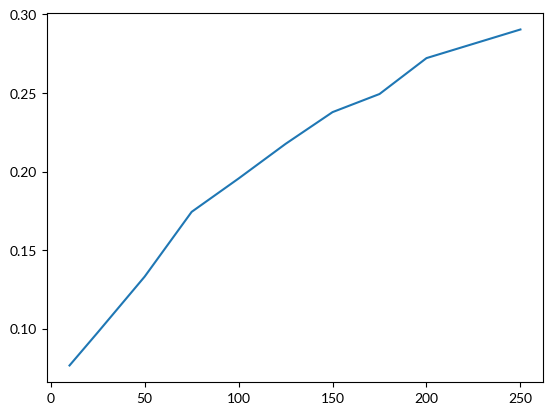

In [199]:
pd.Series(noise, index=sizes).plot()

In [200]:
pd.Series(iner, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_bic_prague.csv')
pd.Series(noise, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_noise_prague.csv')

## Vienna

In [201]:
region_id = 86873
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [14]:
%%time

n_jobs = -1
scores = Parallel(n_jobs=n_jobs)(
    delayed(get_morphotopes)(size, region_id) for size in sizes
)

2026-02-04 17:32:32.334233 ----Processing ------ 69333
--------Generating lag----------
--------Generating morphotopes---------- 250
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe', 'licBAD', 'misBAD', 'ssbCCM', 'ssbCCD']
--------Generating morphotopes data----------
2026-02-04 17:32:32.332067 ----Processing ------ 69333
--------Generating lag----------
--------Generating morphotopes---------- 200
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe', 'licBAD', 'misBAD', 'ssbCCM', 'ssbCCD']
--------Generating morphotopes data----------
2026-02-04 17:32:32.345519 ----Processing ------ 69333
--------Generating lag----------
--------Generating morphotopes---------- 175
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', '

In [202]:
scaler = StandardScaler()
vals = scaler.fit_transform(X_train[X_train.index >= 0])
vals = np.nan_to_num(vals, 0)

In [203]:
iner = []
noise = []
for s in sizes:
    mt = pd.read_parquet(f'/data/uscuni-ulce/sensitivity/tessellation_labels_morphotopes_{region_id}_{s}_0_None_None_False.pq')
    noise_mask = mt.morphotope_label.str.contains("-1")
    noise.append(noise_mask.sum() / noise_mask.shape[0])
    cal = calculate_inertia(vals[~noise_mask], mt.morphotope_label[~noise_mask])
    iner.append(cal)   

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a s

<Axes: >

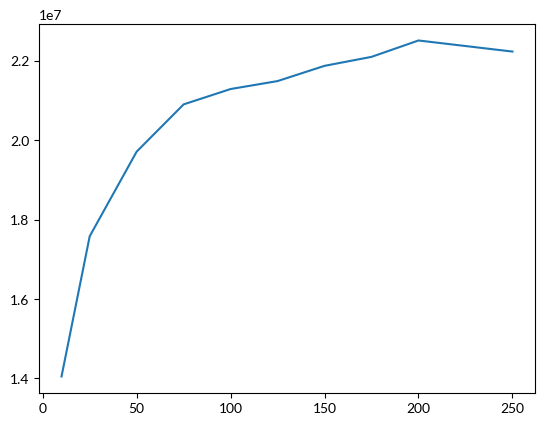

In [176]:
pd.Series(iner, index=sizes).plot()

<Axes: >

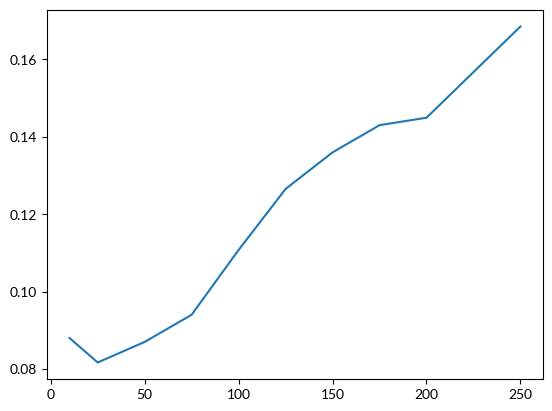

In [204]:
pd.Series(noise, index=sizes).plot()

In [205]:
pd.Series(iner, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_bic_vienna.csv')
pd.Series(noise, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_noise_vienna.csv')

## Bratislava

In [214]:
region_id = 99886
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [ ]:
%%time

n_jobs = -1
scores = Parallel(n_jobs=n_jobs)(
    delayed(get_morphotopes)(size, region_id) for size in sizes
)

In [215]:
scaler = StandardScaler()
vals = scaler.fit_transform(X_train[X_train.index >= 0])
vals = np.nan_to_num(vals, 0)

In [216]:
iner = []
noise = []
for s in sizes:
    mt = pd.read_parquet(f'/data/uscuni-ulce/sensitivity/tessellation_labels_morphotopes_{region_id}_{s}_0_None_None_False.pq')
    noise_mask = mt.morphotope_label.str.contains("-1")
    noise.append(noise_mask.sum() / noise_mask.shape[0])
    cal = calculate_inertia(vals[~noise_mask], mt.morphotope_label[~noise_mask])
    iner.append(cal)   

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a s

<Axes: >

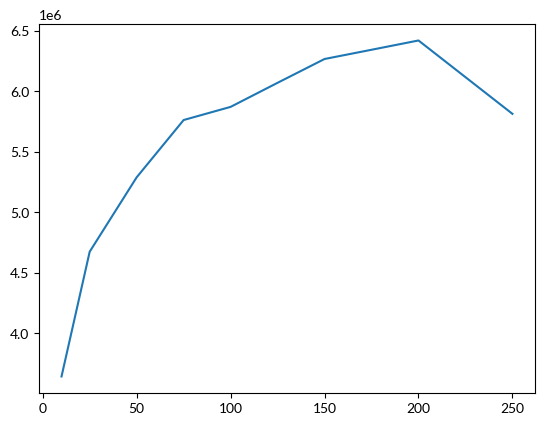

In [217]:
pd.Series(iner, index=sizes).plot()

<Axes: >

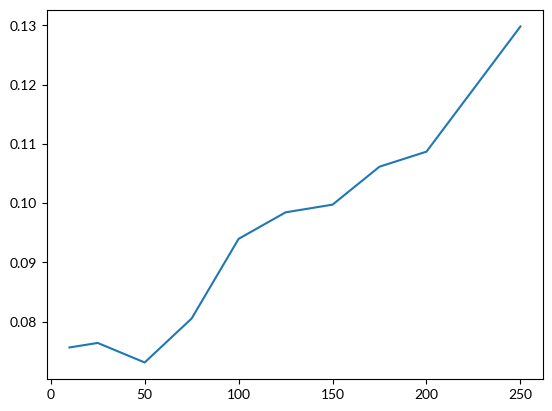

In [218]:
pd.Series(noise, index=sizes).plot()

In [219]:
pd.Series(iner, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_bic_bratislava.csv')
pd.Series(noise, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_noise_bratislava.csv')

## Munich

In [220]:
region_id = 38679
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [ ]:
%%time

n_jobs = -1
scores = Parallel(n_jobs=n_jobs)(
    delayed(get_morphotopes)(size, region_id) for size in sizes
)

2026-02-04 17:36:07.927970 ----Processing ------ 86873
--------Generating lag----------
--------Generating morphotopes---------- 10
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe', 'licBAD', 'misBAD', 'ssbCCM', 'ssbCCD']
--------Generating morphotopes data----------
2026-02-04 17:41:16.216944 ----Processing ------ 99886
--------Generating lag----------
--------Generating morphotopes---------- 250
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe', 'licBAD', 'misBAD', 'ssbCCM', 'ssbCCD']
--------Generating morphotopes data----------
2026-02-04 17:36:07.963173 ----Processing ------ 86873
--------Generating lag----------
--------Generating morphotopes---------- 25
--------Dropping columns---------- ['stcSAl', 'stbOri', 'stcOri', 'stbCeA', 'ldkAre', 'ldkPer', 'ls

In [221]:
scaler = StandardScaler()
vals = scaler.fit_transform(X_train[X_train.index >= 0])
vals = np.nan_to_num(vals, 0)

In [222]:
iner = []
noise = []
for s in sizes:
    mt = pd.read_parquet(f'/data/uscuni-ulce/sensitivity/tessellation_labels_morphotopes_{region_id}_{s}_0_None_None_False.pq')
    noise_mask = mt.morphotope_label.str.contains("-1")
    noise.append(noise_mask.sum() / noise_mask.shape[0])
    cal = calculate_inertia(vals[~noise_mask], mt.morphotope_label[~noise_mask])
    iner.append(cal)   

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a s

<Axes: >

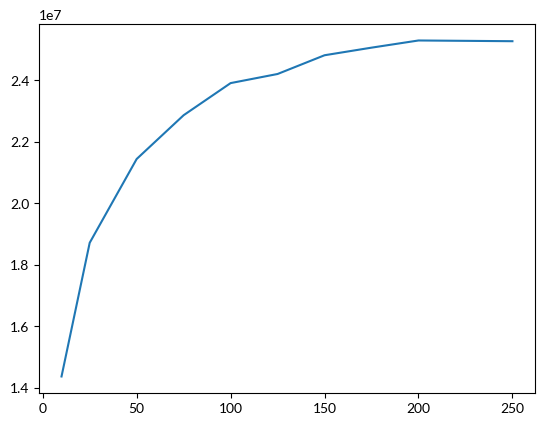

In [223]:
pd.Series(iner, index=sizes).plot()
# munich["0"].plot(ax=ax)

In [224]:
pd.Series(iner, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_bic_munich.csv')
pd.Series(noise, index=sizes).to_csv('/data/uscuni-ulce/sensitivity/sa3_noise_munich.csv')

In [190]:
vienna = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_bic_vienna.csv', index_col=0)
prg = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_bic_prague.csv', index_col=0)
munich = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_bic_munich.csv', index_col=0)
blava = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_bic_bratislava.csv', index_col=0)

In [226]:
vienna_noise = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_noise_vienna.csv', index_col=0)
prg_noise = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_noise_prague.csv', index_col=0)
munich_noise = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_noise_munich.csv', index_col=0)
blava_noise = pd.read_csv('/data/uscuni-ulce/sensitivity/sa3_noise_bratislava.csv', index_col=0)

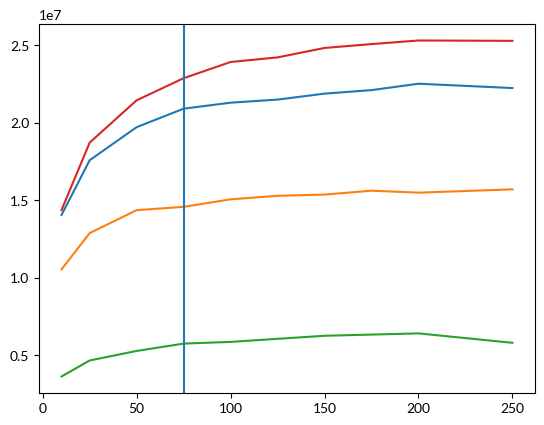

In [227]:
ax = vienna["0"].plot()
prg["0"].plot(ax=ax)
blava["0"].plot(ax=ax)
munich["0"].plot(ax=ax)
ax.axvline(75)

In [192]:
colors = [
    "#4069BC",
    "#7CBAE4",
    "#E69C63",
    "#eec1d5",
    "#E0665F",
    "#ECBF43",
    "#b2cd32",
    "#1F943E",
]

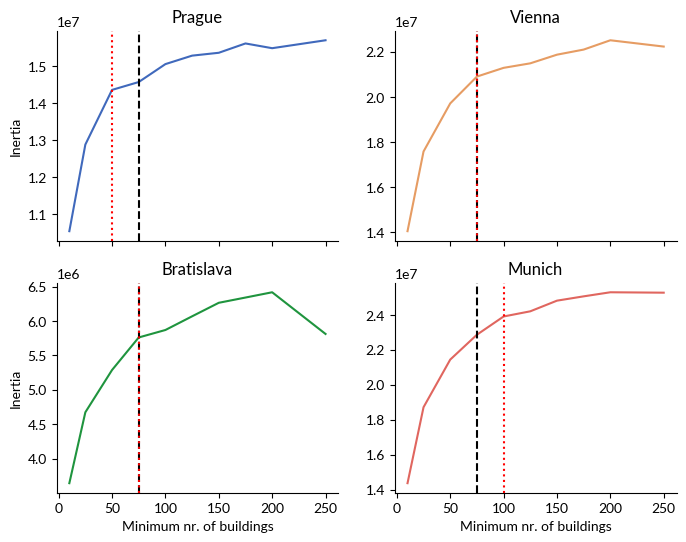

In [243]:
f, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

prg["0"].plot(ax=ax[0][0], color=colors[0])
vienna["0"].plot(ax=ax[0][1], color=colors[2])
blava["0"].plot(ax=ax[1][0], color=colors[7])
munich["0"].plot(ax=ax[1][1], color=colors[4])
for a in ax.flat:
    sns.despine(ax=a)
    a.axvline(75, linestyle="dashed", color='k')
ax[0][0].set_ylabel('Inertia')
ax[1][0].set_ylabel('Inertia')
ax[1][0].set_xlabel('Minimum nr. of buildings')
ax[1][1].set_xlabel('Minimum nr. of buildings')

ax[0][0].set_title('Prague')
ax[0][1].set_title('Vienna')
ax[1][0].set_title('Bratislava')
ax[1][1].set_title('Munich')

ax[0][0].axvline(50, linestyle="dotted", color='r')
ax[0][1].axvline(75, linestyle="dotted", color='r')
ax[1][0].axvline(75, linestyle="dotted", color='r')
ax[1][1].axvline(100, linestyle="dotted", color='r')

# ax00 = ax[0][0].twinx()

# prg_noise["0"].plot(ax=ax00, color=colors[1])

# ax01 = ax[0][1].twinx()
# vienna_noise["0"].plot(ax=ax01, color=colors[1])

# ax10 = ax[1][0].twinx()
# blava_noise["0"].plot(ax=ax10, color=colors[1])

# ax11 = ax[1][1].twinx()
# munich_noise["0"].plot(ax=ax11, color=colors[1])

# for a in [ax00, ax01, ax10, ax11]:
#     a.set_ylim(0, .4)
#     a.spines[['top']].set_visible(False)

plt.savefig("../figs/sa3_inertia.png", dpi=300, bbox_inches="tight")